# Prediction of clinical readmissions in patients with diabetes

**Name:** Carlos Alberto Arbelaez Giraldo

**ID:** 1017212109

**e-mail:** carlos.arbelaezg@udea.edu.co

-------------------------------------------------------
**Name:** Santiago Velásquez 

**ID:**  1036647710

**e-mail:** santiago.velasquez4@udea.edu.co



### Problem description

It is important to know if a patient will be readmitted in some hospital. The reason is that you can change the treatment, in order to avoid a readmission.

In this database, you have 3 different outputs:

1. No readmission;
2. A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate);
3. A readmission in more than 30 days (this one is not so good as well the last one, however, the reason can be the state of the patient.

### Source

The data are submitted on behalf of the Center for Clinical and Translational Research, Virginia Commonwealth University, a recipient of NIH CTSA grant UL1 TR00058 and a recipient of the CERNER data. John Clore (jclore '@' vcu.edu), Krzysztof J. Cios (kcios '@' vcu.edu), Jon DeShazo (jpdeshazo '@' vcu.edu), and Beata Strack (strackb '@' vcu.edu). This data is a de-identified abstract of the Health Facts database (Cerner Corporation, Kansas City, MO).

### Kaggle Link

https://www.kaggle.com/brandao/diabetes

# 1. Imports and configurations

In [5]:
import pandas as pd
import numpy as np
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.neural_network import MLPClassifier

import xgboost as xgb

import matplotlib.pyplot as plt

import pickle
import warnings

warnings.simplefilter('ignore')

In [6]:
df = pd.read_csv('../data/processed/cleanData.csv', index_col=[0])

In [26]:
cat_features = ['race', 'gender', 'discharge_disposition_id', 'admission_source_id',
                'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
                'A1Cresult', 'metformin', 'glimepiride', 'glipizide', 'glyburide',
                'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed']

num_features = ['age', 'time_in_hospital', 'num_medications', 'number_outpatient',
                'number_emergency', 'number_inpatient', 'requests_1', 'requests_10']

y = ['readmitted']

X = cat_features + num_features

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.30, random_state=27)

In [5]:
X_test.to_csv('../data/processed/X_test.csv')
y_test.to_csv('../data/processed/y_test.csv')

##### **Note**: 

Although we'll use algorithms for predictive models where it's not necessary to scalate the features, it could be necessary for further work, for example, for regularization, optimization or if eventually I want to compare another algorithms where it's necessary to normalize the numeric features. So I always consider that is a good thing implement an scaler on the pipelines as a preprocessor.

In [29]:
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [30]:
def metrics(y_test, y_pred):
    '''Generate f1, recall, accuracy and the confusion matrix for y_test / y_pred'''
    f1 = f1_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return f1, rec, acc, cm

## Logistic Regresion

In [12]:
if os.path.exists('../models/lr1.pkl'):
    lr1 = joblib.load('../models/lr1.pkl')

else:
    lr1 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])
    lr1.fit(X_train, y_train)
    joblib.dump(lr1, '../models/lr1.pkl')

In [13]:
y_pred = lr1.predict(X_test)
lr_f1, lr_rec, lr_acc, lr_cm = metrics(y_test, y_pred)

## Random Forest Classifier

In [14]:
if os.path.exists('../models/rf1.pkl'):
    rf1 = joblib.load('../models/rf1.pkl')
else:
    rf1 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])
    rf1.fit(X_train,y_train)
    joblib.dump(rf1, '../models/rf1.pkl')

In [15]:
y_pred = rf1.predict(X_test)
rf_f1, rf_rec, rf_acc, rf_cm = metrics(y_test, y_pred)

<AxesSubplot:ylabel='feature'>

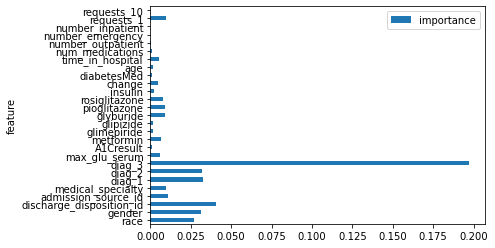

In [16]:
fi = list(zip(X_train.columns.values, rf1.steps[1][1].feature_importances_))

pd.DataFrame(columns = ['feature', 'importance'], data = fi).plot.barh(x='feature', y='importance')

## Decision Tree

In [17]:
if os.path.exists('../models/dt1.pkl'):
    dt1 = joblib.load('../models/dt1.pkl')
    
else:    
    dt1 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())])
    dt1.fit(X_train,y_train)
    joblib.dump(dt1, '../models/dt1.pkl')

In [18]:
y_pred = dt1.predict(X_test)
dt_f1, dt_rec, dt_acc, dt_cm = metrics(y_test, y_pred)

<AxesSubplot:ylabel='feature'>

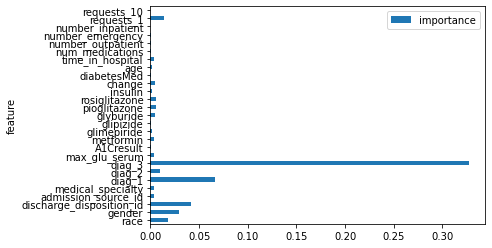

In [19]:
fi = list(zip(X_train.columns.values, dt1.steps[1][1].feature_importances_))
pd.DataFrame(columns = ['feature', 'importance'], data = fi).plot.barh(x='feature', y='importance')

## Neural Net

In [20]:
if os.path.exists('../models/NN.pkl'):
    NN = joblib.load('../models/NN.pkl')

else:
    NN = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100), random_state=1))])
                      
    NN.fit(X_train, y_train)

    joblib.dump(NN, '../models/NN.pkl')

                      
if os.path.exists('../models/NN2.pkl'):
    NN2 = joblib.load('../models/NN2.pkl')

else:    
    NN2 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 7, 3), random_state=1))])
    
    NN2.fit(X_train, y_train)

    joblib.dump(NN2, '../models/NN2.pkl')

In [21]:
y_pred = NN.predict(X_test)
NN_f1, NN_rec, NN_acc, NN_cm = metrics(y_test,y_pred)

y_pred = NN2.predict(X_test)
NN2_f1, NN2_rec, NN2_acc, NN2_cm = metrics(y_test,y_pred)

### XGBoost

In [22]:
if os.path.exists('../models/xgb_pipeline.pkl'):
    xgb_pipeline = joblib.load('../models/xgb_pipeline.pkl')
    
else:    
    xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('xgb_model', xgb.XGBClassifier())])
    xgb_pipeline.fit(X_train, y_train)
    joblib.dump(xgb_pipeline, '../models/xgb_pipeline.pkl')

[19:19:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [23]:
y_pred = xgb_pipeline.predict(X_test)
xgb_f1, xgb_rec, xgb_acc, xgb_cm = metrics(y_test, y_pred)

<AxesSubplot:ylabel='feature'>

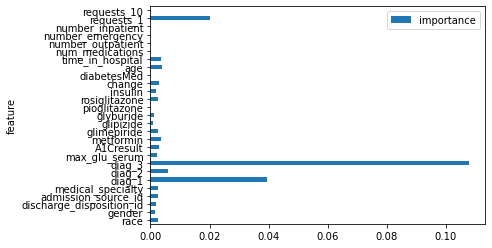

In [24]:
fi = list(zip(X_train.columns.values, xgb_pipeline.steps[1][1].feature_importances_))
pd.DataFrame(columns = ['feature', 'importance'], data = fi).plot.barh(x='feature', y='importance')

## Comparison of the models

In [26]:
data = {'Model':['LogisticRegression','RandomForest','Decision Tree', 'NN 1 Hidden Layer', 'NN 3 Hidden Layers', 'XGB'],
    'Accuracy':[lr_acc,rf_acc,dt_acc, NN_acc, NN2_acc, xgb_acc], 
    'Recall':[lr_rec, rf_rec, dt_rec, NN_rec, NN2_rec, xgb_rec], 
    'F1':[lr_f1, rf_f1, dt_f1, NN_f1, NN2_f1, xgb_f1]}
comp = pd.DataFrame(data)
comp

,Model,Accuracy,Recall,F1
0,LogisticRegression,0.750952,0.617468,0.698964
1,RandomForest,0.797457,0.747568,0.775610
2,Decision Tree,0.728413,0.700595,0.707245
3,NN 1 Hidden Layer,0.752380,0.679832,0.719975
4,NN 3 Hidden Layers,0.765638,0.774866,0.755878
5,XGB,0.807112,0.717293,0.776913


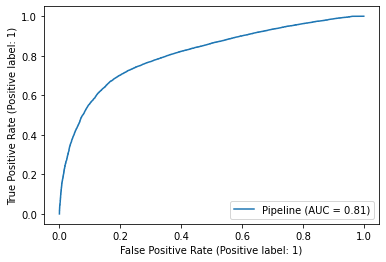

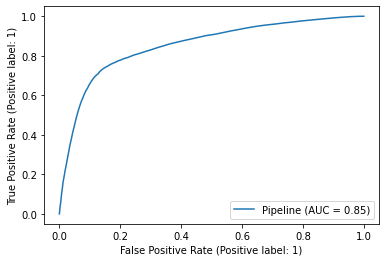

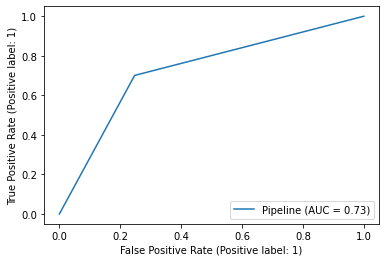

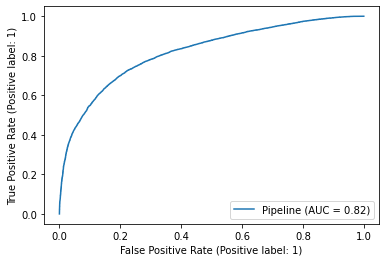

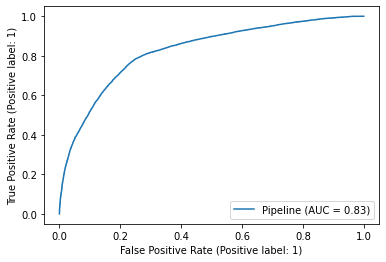

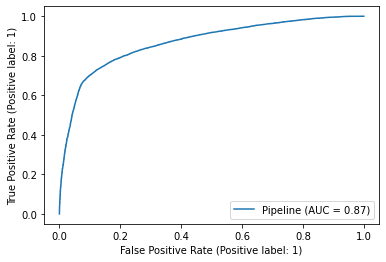

In [27]:
plot_roc_curve(lr1,X_test,y_test)
plot_roc_curve(rf1,X_test,y_test)
plot_roc_curve(dt1,X_test,y_test)
plot_roc_curve(NN, X_test, y_test)
plot_roc_curve(NN2, X_test, y_test)
plot_roc_curve(xgb_pipeline, X_test, y_test)

#### Conclusion: The best of the proposed model for comparison was the Random Forest Classifier. It was the best on the overall metrics, but also it has the best ROC Curve and the best numbers on the confusion matrix. I'll select this model to perform hyperparameter tunning.

## Hyperparameter tunning

In [ ]:
parameters = {
  'n_estimators':[1,10,100,1000],
  'min_samples_split': [2,3,4,5]
  }

rf2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GridSearchCV(RandomForestClassifier(),parameters,cv=2,refit=True))])
rf2.fit(X_train,y_train)

In [ ]:
y_pred = rf2.predict(X_test)
rf2_f1, rf2_rec, rf2_acc, rf2_cm = metrics(y_test,y_pred)

In [ ]:
data = {'Model':['Best RF'],
    'Accuracy':[rf2_acc], 
    'Recall':[rf2_rec], 
    'F1':[rf2_f1]}
pd.DataFrame(data)

In [ ]:
import joblib

joblib.dump(rf2,'../models/best.pkl')

# Retomando el problema multiclase

In [13]:
original = pd.read_csv('../data/raw/diabetic_data.csv')

In [20]:
df = df.join(original['readmitted'], how='left', rsuffix='_original')
df['readmitted_original'] = df['readmitted_original'].astype('category')

In [31]:
y = ['readmitted_original']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.30, random_state=27)

In [42]:
def metrics2(y_test, y_pred):
    '''Generate f1, recall, accuracy and the confusion matrix for y_test / y_pred'''
    f1 = f1_score(y_test,y_pred, average='weighted')
    rec = recall_score(y_test,y_pred, average='weighted')
    acc = accuracy_score(y_test,y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return f1, rec, acc, cm

## Logistic Regression Multiclase

In [35]:
if os.path.exists('../models/lr2.pkl'):
    lr2 = joblib.load('../models/lr2.pkl')

else:
    lr2 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])
    lr2.fit(X_train, y_train)
    joblib.dump(lr2, '../models/lr2.pkl')

In [43]:
y_pred = lr2.predict(X_test)
lr2_f1, lr2_rec, lr2_acc, l2r_cm = metrics2(y_test, y_pred)

## Random Forest Multiclase

In [47]:
if os.path.exists('../models/rf2.pkl'):
    rf2 = joblib.load('../models/rf2.pkl')
else:
    rf2 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])
    rf2.fit(X_train,y_train)
    joblib.dump(rf2, '../models/rf2.pkl')

In [49]:
y_pred = rf2.predict(X_test)
rf2_f1, rf2_rec, rf2_acc, rf2_cm = metrics2(y_test, y_pred)

## Decision Tree

In [50]:
if os.path.exists('../models/dt2.pkl'):
    dt2 = joblib.load('../models/dt2.pkl')
    
else:    
    dt2 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())])
    dt2.fit(X_train,y_train)
    joblib.dump(dt2, '../models/dt2.pkl')

In [51]:
y_pred = dt2.predict(X_test)
dt2_f1, dt2_rec, dt2_acc, dt2_cm = metrics2(y_test, y_pred)

## XGBoost Multiclase

In [52]:
if os.path.exists('../models/xgb2_pipeline.pkl'):
    xgb2_pipeline = joblib.load('../models/xgb2_pipeline.pkl')
    
else:    
    xgb2_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('xgb_model', xgb.XGBClassifier())])
    xgb2_pipeline.fit(X_train, y_train)
    joblib.dump(xgb2_pipeline, '../models/xgb2_pipeline.pkl')

[11:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
y_pred = xgb2_pipeline.predict(X_test)
xgb2_f1, xgb2_rec, xgb2_acc, xgb2_cm = metrics2(y_test, y_pred)

## Neuralnet Multiclase

In [58]:
if os.path.exists('../models/NN_b.pkl'):
    NN_b = joblib.load('../models/NN_b.pkl')

else:
    NN_b = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100), random_state=1))])
                      
    NN_b.fit(X_train, y_train)

    joblib.dump(NN_b, '../models/NN_b.pkl')

                      
if os.path.exists('../models/NN2_b.pkl'):
    NN2_b = joblib.load('../models/NN2_b.pkl')

else:    
    NN2_b = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 7, 3), random_state=1))])
    
    NN2_b.fit(X_train, y_train)

    joblib.dump(NN2_b, '../models/NN2_b.pkl')

In [60]:
y_pred = NN_b.predict(X_test)
NN_b_f1, NN_b_rec, NN_b_acc, NN_b_cm = metrics2(y_test,y_pred)

y_pred = NN2_b.predict(X_test)
NN2_b_f1, NN2_b_rec, NN2_b_acc, NN2_b_cm = metrics2(y_test,y_pred)

## Metrics

In [61]:
data = {'Model':['LogisticRegression','RandomForest','Decision Tree', 'XGB', 'NN 1 Hidden Layer', 'NN 3 Hidden Layers'],
    'Accuracy':[lr2_acc,rf2_acc,dt2_acc,  xgb2_acc, NN_b_acc, NN_b_acc], 
    'Recall':[lr2_rec, rf2_rec, dt2_rec,  xgb2_rec, NN_b_rec, NN_b_rec], 
    'F1':[lr2_f1, rf2_f1, dt2_f1, xgb2_f1, NN_b_f1, NN_b_f1]}
comp = pd.DataFrame(data)
comp

,Model,Accuracy,Recall,F1
0,LogisticRegression,0.667154,0.667154,0.623715
1,RandomForest,0.707982,0.707982,0.668345
2,Decision Tree,0.621057,0.621057,0.616291
3,XGB,0.719404,0.719404,0.683599
4,NN 1 Hidden Layer,0.672423,0.672423,0.642421
5,NN 3 Hidden Layers,0.672423,0.672423,0.642421
